# Deteksi penyakit daun tomat menggunakan metode CNN

**Daun tomat memiliki sembilan penyakit berbeda seperti, Bintik target, Virus mosaik tomat, Virus keriting daun kuning tomat, Bintik bakteri, Penyakit busuk daun, Penyakit busuk daun, Jamur daun, Bercak daun Septoria, dan Tungau laba-laba dua tungau laba-laba berbintik. Proyek ini bertujuan untuk mendeteksi penyakit pada citra daun tomat dan mengklasifikasikan citra ke dalam sepuluh kelas berbeda menggunakan CNN.**

**Set data untuk proyek ini tersedia di situs web Kaggle 'https://www.kaggle.com/datasets/noulam/tomato'.**

## Impor Library yang Dibutuhkan

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Impor Dataset

In [3]:
data_train = "/content/drive/MyDrive/Skripsi/citrus_leaf_disease/Dataset Jeruk Siam/train"
data_test = "/content/drive/MyDrive/Skripsi/citrus_leaf_disease/Dataset Jeruk Siam/validation"

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

## Memuat data Gambar sebagai batch ke set data tensorflow

**API tf.keras.preprocessing.image_dataset_from_directory(main_directory, labels = 'inferred') akan mengembalikan tf.data.Dataset yang menghasilkan kumpulan gambar dari subdirektori bersama dengan label.**

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1200 files belonging to 6 classes.


**Menampilkan 10 nama kelas.**

In [6]:
class_names = dataset.class_names
class_names

['Blackspot Leaf',
 'Canker Leaf',
 'Citrus Leafminer',
 'Greening Leaf',
 'Healthy Leaf',
 'Powdery Mildew']

**Menampilkan kumpulan data. Ini memiliki 32 gambar, dengan masing-masing gambar berukuran 256 kali 256 dan 3 adalah saluran RGB.**

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[4 1 2 3 2 2 0 1 4 0 1 3 0 4 1 2 0 5 0 3 3 1 2 3 3 1 5 2 5 1 2 2]


**Memvisualisasikan 12 gambar dari kumpulan 32 gambar dengan nama kelasnya.**

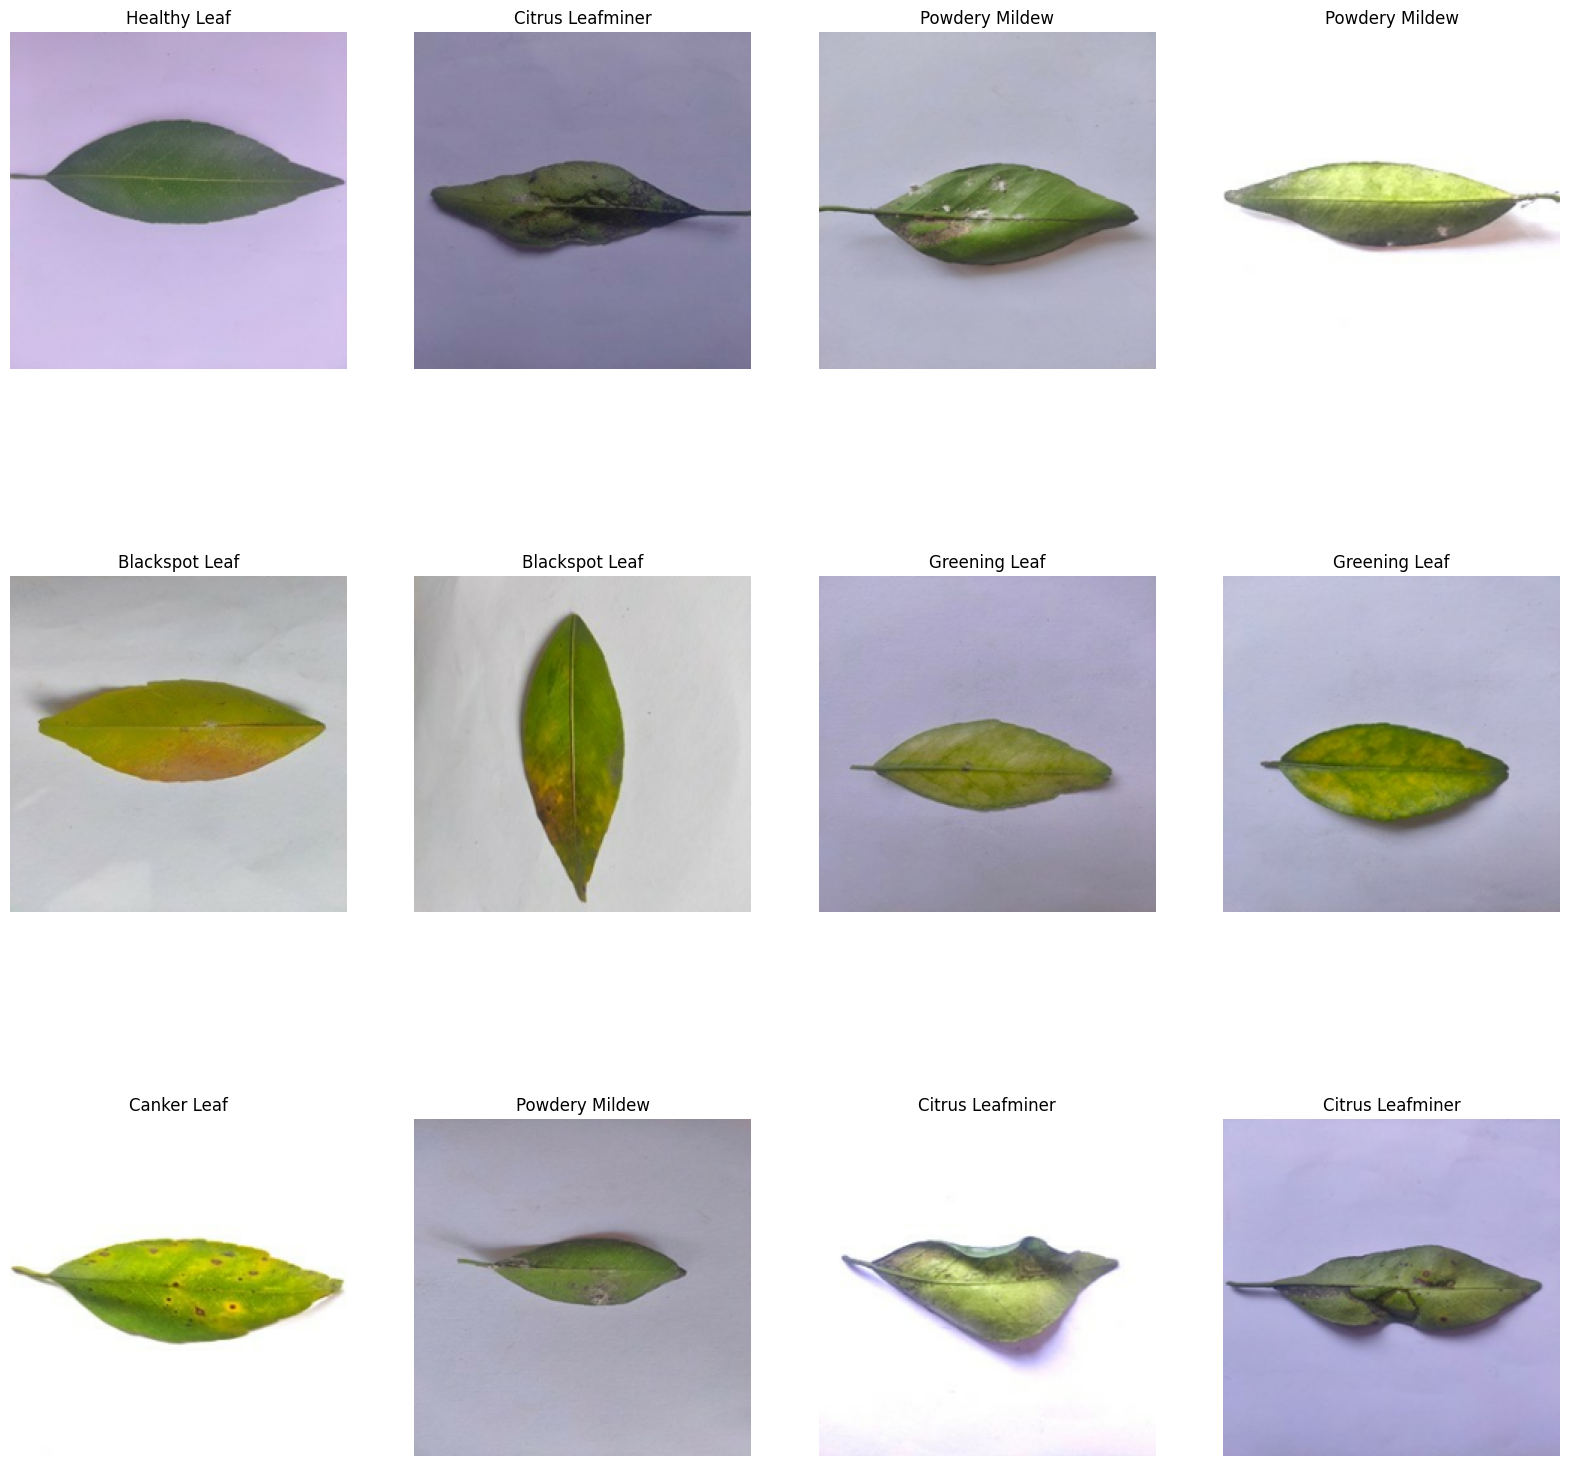

In [8]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Memisahkan kumpulan data (Splitting)

**Panjang dataset adalah 313. Dari jumlah tersebut, 80% data akan digunakan untuk pelatihan, 10% data sisanya akan digunakan untuk validasi, dan 10% data terakhir akan digunakan untuk pengujian model.**

**get_dataset_partition() adalah fungsi yang mengacak set data dan membagi set data menjadi pelatihan, validasi, dan pengujian model.**

In [9]:
# Melakukan 80% training dan 20% yaitu 10% validation, 10% test
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache, Shuffle, dan Prefetch dataset

**cache() di sini membaca image dari disk dan menyimpannya di memori. Iterasi berikutnya akan menggunakan kembali gambar yang di-cache selama transformasi cache.**

**prefetch() digunakan untuk memisahkan waktu ketika data dihasilkan dari waktu ketika data dikonsumsi. Transformasi ini menggunakan thread latar belakang dan buffer internal untuk mengambil lebih dulu elemen dari set data masukan sebelum diminta.**

**AUTOTUNE, yang akan menampilkan tf. runtime data untuk menyempurnakan nilai secara dinamis saat runtime.**

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Menskalakan Gambar (Scaling the Image)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

## Augmentasi Data (Data Augmentation)

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Menerapkan Augmentasi Data untuk Melatih Dataset

In [14]:
# Apply data augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

## Pembuatan Model menggunakan Convolutional Neural Network (CNN)

**Menggunakan CNN yang digabungkan dengan aktivasi Softmax di lapisan output. Juga menambahkan pengubahan ukuran, normalisasi, dan Augmentasi Data sebagai lapisan awal.**

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

### Mengkompilasi Model

**Menggunakan adam Optimizer, SparseCategoricalCrossentropy untuk kerugian dan akurasi sebagai metrik.**

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/100
30/30 [==============================] - 210s 4s/step - loss: 1.5284 - accuracy: 0.2987 - val_loss: 1.3554 - val_accuracy: 0.3125
Epoch 2/100
30/30 [==============================] - 100s 3s/step - loss: 1.1349 - accuracy: 0.4809 - val_loss: 1.1989 - val_accuracy: 0.4479
Epoch 3/100
30/30 [==============================] - 111s 4s/step - loss: 1.2139 - accuracy: 0.4227 - val_loss: 1.1492 - val_accuracy: 0.3750
Epoch 4/100
30/30 [==============================] - 102s 3s/step - loss: 1.0687 - accuracy: 0.4799 - val_loss: 1.0126 - val_accuracy: 0.5625
Epoch 5/100
30/30 [==============================] - 105s 3s/step - loss: 0.9731 - accuracy: 0.5424 - val_loss: 0.9685 - val_accuracy: 0.5625
Epoch 6/100
30/30 [==============================] - 103s 3s/step - loss: 0.9520 - accuracy: 0.5371 - val_loss: 1.0672 - val_accuracy: 0.6146
Epoch 7/100
30/30 [==============================] - 100s 3s/step - loss: 0.9393 - accuracy: 0.5614 - val_loss: 0.9976 - val_accuracy: 0.6146
Epoch 

### Akurasi pengujian adalah 0,9521

In [19]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 9s 1s/step - loss: 0.0132 - accuracy: 0.9937


### Memploting Grafik Training and Validation pada Accuracy & Loss

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

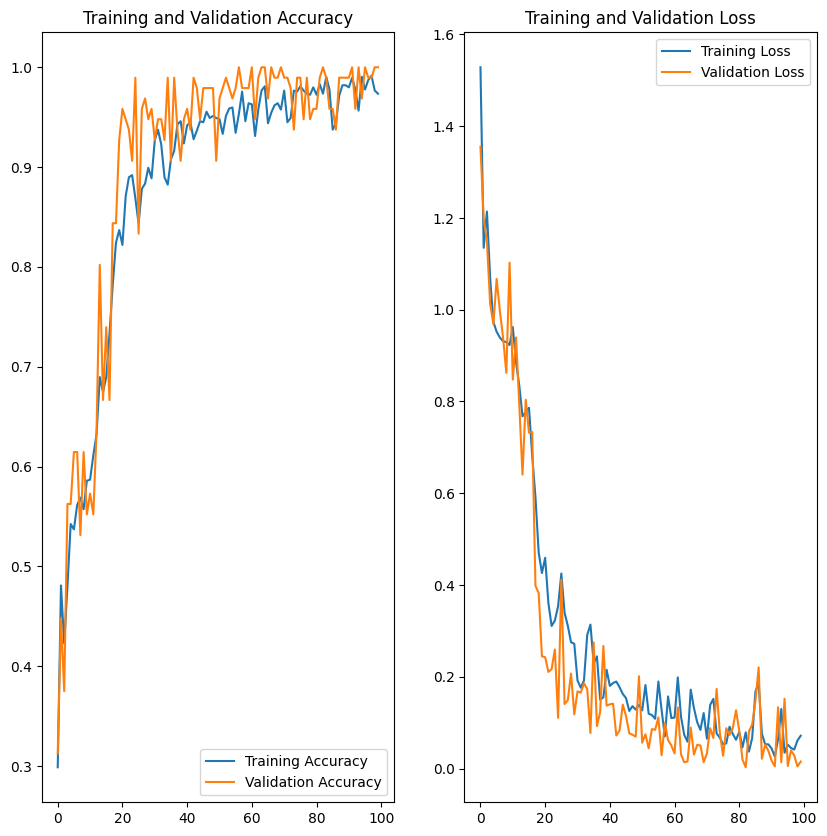

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

5/5 [==============================] - 4s 770ms/step


<Figure size 800x800 with 0 Axes>

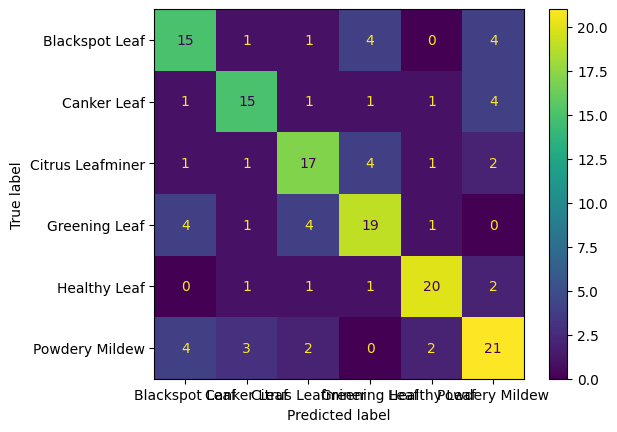

Classification Report:
                  precision    recall  f1-score   support

  Blackspot Leaf       0.60      0.60      0.60        25
     Canker Leaf       0.68      0.65      0.67        23
Citrus Leafminer       0.65      0.65      0.65        26
   Greening Leaf       0.66      0.66      0.66        29
    Healthy Leaf       0.80      0.80      0.80        25
  Powdery Mildew       0.64      0.66      0.65        32

        accuracy                           0.67       160
       macro avg       0.67      0.67      0.67       160
    weighted avg       0.67      0.67      0.67       160



In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Prediksi label untuk dataset pengujian
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# Menampilkan confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

# Menampilkan classification report untuk presisi, recall, dan f1 score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

**Grafik Akurasi Pelatihan dan Validasi di atas menunjukkan bahwa dengan peningkatan Akurasi Pelatihan terjadi peningkatan Akurasi Validasi.**

**Dari grafik Training and Validation loss, terlihat bahwa dengan penurunan training loss terjadi penurunan validasi loss.**

### Memprediksi gambar

first image to predict
actual label: Blackspot Leaf
1/1 [==============================] - 1s 902ms/step
predicted label: Blackspot Leaf


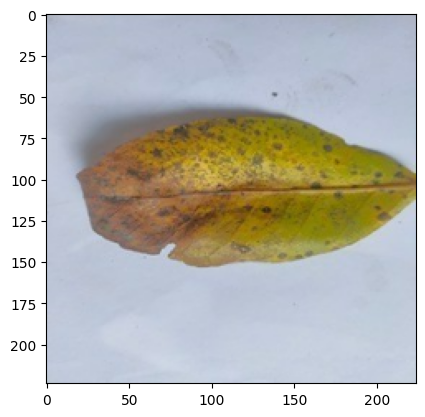

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**predict() digunakan untuk memprediksi gambar dan menyediakan nama class Predicted dengan Confidence.**

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


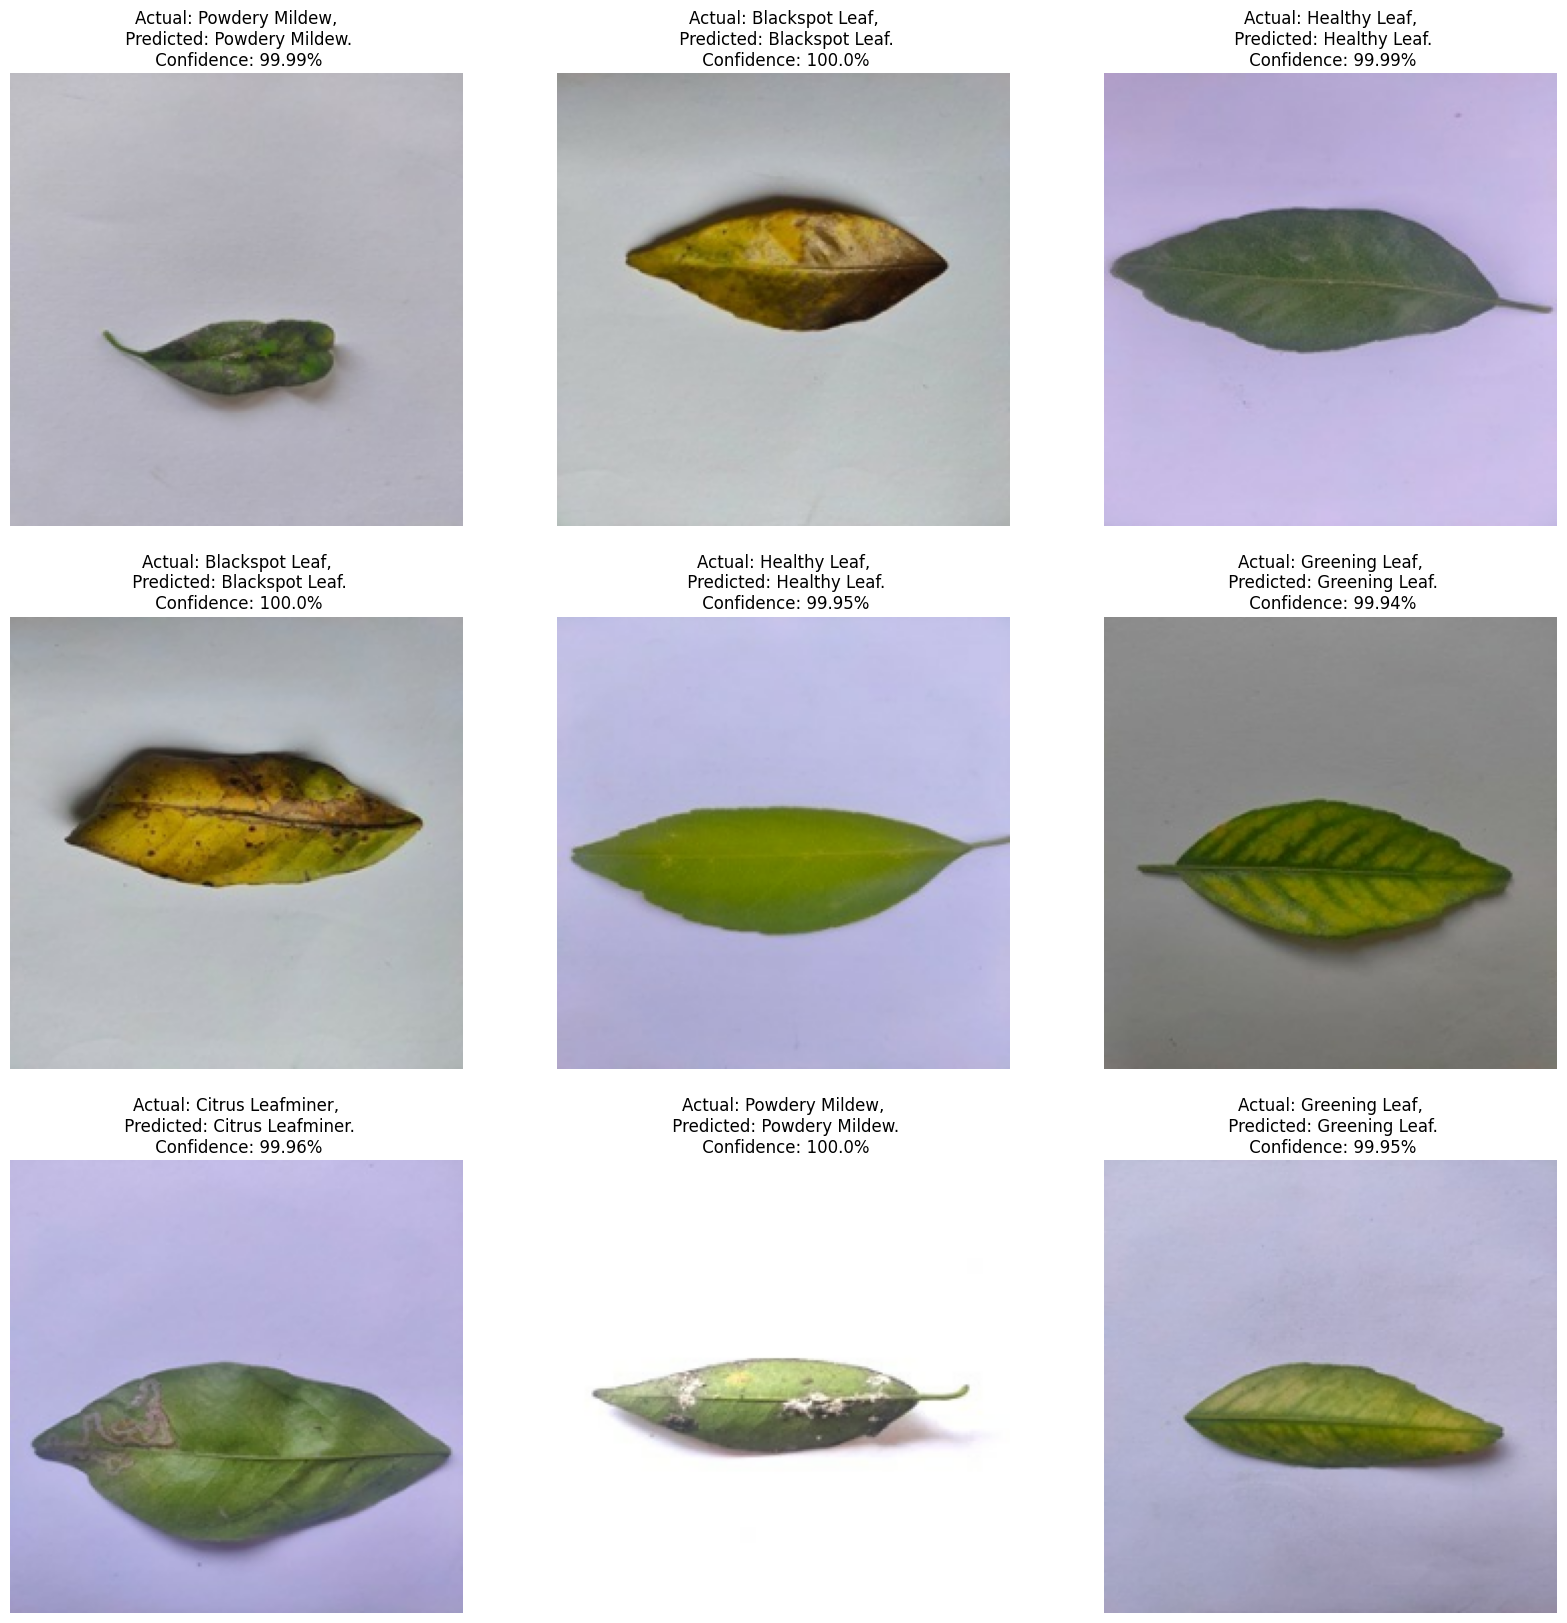

In [25]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Output dengan jelas menunjukkan bahwa model mampu memprediksi semua gambar dengan benar dan performa model signifikan.**

### Simpan Model

In [26]:
model.save("citrusleafdetection_cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
import os

model_name = 'CNN'
subject = 'JerukSiamChecker'
# acc = test_image[1] * 100
save_path = '/content/drive/MyDrive/Skripsi/citrus_leaf_disease'

save_id = str(f'{model_name}-{subject}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as /content/drive/MyDrive/Skripsi/citrus_leaf_disease/CNN-JerukSiamChecker.h5
